In [1]:
# from mf.mf import godec
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve, auc
import inspect

# Plot options
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['legend.loc'] = 'lower right'
plt.rcParams['legend.fontsize'] = 14

In [2]:
#load data
path = "E:\MY\paper\FDILocation\code\data\case14"
# detection
a_new_sin5_sum = scio.loadmat(path+"\\LRMF\\a_new_sin5.mat")['A']

a_new_um5_pbt2_sum = scio.loadmat(path+"\\LRMF\\a_new_um5-pbt2.mat")['A']
a_new_um5_pbt3_sum = scio.loadmat(path+"\\LRMF\\a_new_um5-pbt3.mat")['A']
a_new_um5_pbt4_sum = scio.loadmat(path+"\\LRMF\\a_new_um5-pbt4.mat")['A']
a_new_um5_pbt5_sum = scio.loadmat(path+"\\LRMF\\a_new_um5-pbt5.mat")['A']


a_new_co5_pbt2_sum = scio.loadmat(path+"\\LRMF\\a_new_co5-pbt2.mat")['A']
a_new_co5_pbt3_sum = scio.loadmat(path+"\\LRMF\\a_new_co5-pbt3.mat")['A']
a_new_co5_pbt4_sum = scio.loadmat(path+"\\LRMF\\a_new_co5-pbt4.mat")['A']
a_new_co5_pbt5_sum = scio.loadmat(path+"\\LRMF\\a_new_co5-pbt5.mat")['A']


H = scio.loadmat(path+"\\H.mat")['h']
# config
att_times_sin = 100
att_times_mul = 100


In [3]:
def estimate_c(H, A_new, times):
    P_inv = np.linalg.inv(H.T@H)
    c_new = []
    for i in range(times):
        c_est = P_inv@H.T@A_new[i,:].T
        c_new.append(c_est)
    c_new = np.array(c_new)
    return c_new

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [4]:
c_new_sin5_sum = estimate_c(H, a_new_sin5_sum, att_times_sin)

c_new_um5_pbt2_sum = estimate_c(H, a_new_um5_pbt2_sum, att_times_mul)
c_new_um5_pbt3_sum = estimate_c(H, a_new_um5_pbt3_sum, att_times_mul)
c_new_um5_pbt4_sum = estimate_c(H, a_new_um5_pbt4_sum, att_times_mul)
c_new_um5_pbt5_sum = estimate_c(H, a_new_um5_pbt5_sum, att_times_mul)

c_new_co5_pbt2_sum = estimate_c(H, a_new_co5_pbt2_sum, att_times_mul)
c_new_co5_pbt3_sum = estimate_c(H, a_new_co5_pbt3_sum, att_times_mul)
c_new_co5_pbt4_sum = estimate_c(H, a_new_co5_pbt4_sum, att_times_mul)
c_new_co5_pbt5_sum = estimate_c(H, a_new_co5_pbt5_sum, att_times_mul)

attack_type_list = [c_new_um5_pbt2_sum, c_new_um5_pbt3_sum, c_new_um5_pbt4_sum, c_new_um5_pbt5_sum,
                    c_new_co5_pbt2_sum, c_new_co5_pbt3_sum, c_new_co5_pbt4_sum, c_new_co5_pbt5_sum]

for i in attack_type_list:
    name = retrieve_name(i)[0]
    # print(name)
    dir = f"E:\MY\paper\FDILocation\code\data\case14\c_new\{name}.mat"
    scio.savemat(dir, {'cnew': i})

In [5]:
from powercase14 import power_env
from config_mea_idx import define_mea_idx_noise
from pypower.api import case14
from pypower.idx_bus import PD, QD
from pypower.idx_brch import RATE_A, BR_X
from gen_data import gen_case, gen_load
from MTD import mtd

In [6]:
# Instance power env
case_name = 'case14'
case = case14()
case = gen_case(case, 'case14')
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'FULL')
_, _ = gen_load(case, 'case14')
case_env = power_env(case = case, case_name = case_name, noise_sigma = noise_sigma, idx = mea_idx, fpr = 0.05)
pb = mtd(case_env=case_env)

Load file found, loading the data...
Initial OPF tests ok.
************************************************************


In [7]:
pbt_sin5 = pb.pbtime_loop(c_new_sin5_sum,att_times_sin)

pbt_um5_pbt2 = pb.pbtime_loop(c_new_um5_pbt2_sum,att_times_mul)
pbt_um5_pbt3 = pb.pbtime_loop(c_new_um5_pbt3_sum,att_times_mul)
pbt_um5_pbt4 = pb.pbtime_loop(c_new_um5_pbt4_sum,att_times_mul)
pbt_um5_pbt5 = pb.pbtime_loop(c_new_um5_pbt5_sum,att_times_mul)


pbt_co5_pbt2 = pb.pbtime_loop(c_new_co5_pbt2_sum,att_times_mul)
pbt_co5_pbt3 = pb.pbtime_loop(c_new_co5_pbt3_sum,att_times_mul)
pbt_co5_pbt4 = pb.pbtime_loop(c_new_co5_pbt4_sum,att_times_mul)
pbt_co5_pbt5 = pb.pbtime_loop(c_new_co5_pbt5_sum,att_times_mul)

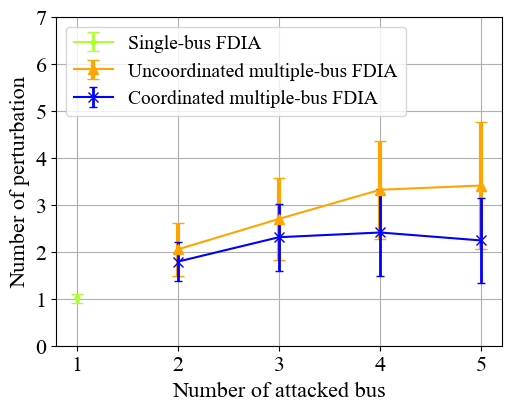

In [9]:
y_sin = np.mean(pbt_sin5)
y_sin_error = np.std(pbt_sin5)
x_sin = [1]

y_um = [np.mean(pbt_um5_pbt2),np.mean(pbt_um5_pbt3),
        np.mean(pbt_um5_pbt4),np.mean(pbt_um5_pbt5)]
y_um_error = [np.std(pbt_um5_pbt2),np.std(pbt_um5_pbt3),
              np.std(pbt_um5_pbt4),np.std(pbt_um5_pbt5)]
x_um = [2,3,4,5]

y_co = [np.mean(pbt_co5_pbt2),np.mean(pbt_co5_pbt3),
        np.mean(pbt_co5_pbt4),np.mean(pbt_co5_pbt5)]
y_co_error = [np.std(pbt_co5_pbt2),np.std(pbt_co5_pbt3),
              np.std(pbt_co5_pbt4),np.std(pbt_co5_pbt5)]
x_co = [2,3,4,5]

plt.grid()
l_sin_pbt =plt.errorbar(x_sin,y_sin,yerr=y_sin_error,fmt='.-',color='greenyellow',
			elinewidth=2,ms=7,capsize=4)
l_um_pbt =plt.errorbar(x_um,y_um,yerr=y_um_error,fmt='^-',color='orange',
			elinewidth=3,ms=7,capsize=4)
l_co_pbt =plt.errorbar(x_co,y_co,yerr=y_co_error,fmt='x-',color='b',
			elinewidth=2,ms=7,capsize=3)

plt.ylim(0,7)
plt.xlabel('Number of attacked bus')
plt.ylabel('Number of perturbation')
plt.legend(handles=[l_sin_pbt,l_um_pbt,l_co_pbt],labels=['Single-bus FDIA',
                                                         'Uncoordinated multiple-bus FDIA',
                                                         'Coordinated multiple-bus FDIA'],
           loc ='upper left')
plt.savefig("E:\\MY\\paper\\FDILocation\\code\\pic\\CDF\\0801\\pbt.eps", dpi=600)